# 10 minutes to cuxfilter

This is a short introduction to the cuxfilter.py library, mostly going over the basic usage and features provided as a quick summary.

### What is cuxfilter?

cuxfilter is inspired from the Crossfilter library, which is a fast, browser-based filtering mechanism across multiple dimensions and offers features do groupby operations on top of the dimensions. One of the major limitations of using Crossfilter is that it keeps data in-memory on a client-side browser, making it inefficient for processing large datasets.

cuxfilter solves the issues by leveraging the power of the rapids.ai stack, mainly cudf. The data is maintained in a gpu as a GPU DataFrame and operations like groupby aggregations, sorting and querying are done on the gpu itself, only returning the result as the output to the charts.

cuxfilter acts as a `connector` library, which provides the connections between different visualization libraries and a GPU dataframe without much hassle. This also allows the user to use charts from different libraries in a single dashboard, while also providing the interaction.

cuxfilter uses data-tiles on the front-end, which are precomputed aggregations, for all possible interactions for a single chart, for updating all remaining charts in a dashboard. data-tiles are just smartly computed groupbys, and generally take around 250ms per chart for a 100M row dataset(do the rest of the math!!!!, ps: its fast!). Once it's downloaded, interactions are seamless, and well, realtime.

### The modules

> cuxfilter has following usable modules

1. cuxfilter.DataFrame
2. cuxfilter.DashBoard
3. cuxfilter.charts
4. cuxfilter.layouts
5. cuxfilter.themes
6. cuxfilter.assets

### Usage

#### 1. Import the required modules

In [ ]:
import cuxfilter
from cuxfilter import DataFrame, themes, layouts
from cuxfilter.assets.custom_tiles import get_provider, Vendors

#### Download required datasets

In [ ]:
#update data_dir if you have downloaded datasets elsewhere
DATA_DIR = './'

! curl https://s3.us-east-2.amazonaws.com/rapidsai-data/viz-data/auto_accidents.arrow.gz --create-dirs -o $DATA_DIR/auto_accidents.arrow.gz

In [ ]:
from cuxfilter.sampledata import datasets_check
datasets_check('auto_accidents', base_dir=DATA_DIR)

#### 2. Read some data

> cuxfilter can read arrow files off disk, or an inmemory cudf dataframe

In [6]:
#create cuxfilter DataFrame
cux_df = DataFrame.from_arrow(DATA_DIR + './auto_accidents.arrow')
cux_df.data['ST_CASE'] = cux_df.data['ST_CASE'].astype('float64')
cux_df.data.head()

,STATE,ST_CASE,VEH_NO,PER_NO,COUNTY,CITY,DAY,MONTH,YEAR,DAY_WEEK,...,ROUTE,RELJCT2,AGE,LAG_HRS,ALC_RES,UNITS_SOLD,LATITUDE,LONGITUD,dropoff_x,dropoff_y
__index_level_0__,,,,,,,,,,,,,,,,,,,,,
0,1,10001.0,1,1,831,968,19,2,2017,1,...,1,1,42,0,0.96,186161.0,33.335661,-87.007094,-9.685585e+06,3.939943e+06
1,1,10002.0,1,1,1009,5923,14,2,2017,3,...,1,1,43,0,0.00,150219.0,34.661528,-86.786853,-9.661068e+06,4.117979e+06
2,1,10003.0,1,1,1120,8314,31,1,2017,3,...,1,1,63,999,0.00,0.0,32.366519,-86.145281,-9.589649e+06,3.811519e+06
3,1,10003.0,2,1,1120,8314,31,1,2017,3,...,1,1,47,0,0.00,207479.0,32.366519,-86.145281,-9.589649e+06,3.811519e+06
4,1,10003.0,3,1,1120,8314,31,1,2017,3,...,1,1,64,999,0.96,0.0,32.366519,-86.145281,-9.589649e+06,3.811519e+06


#### 3. Create some charts

> see charts section to see available chart options

In [ ]:
demo_red_blue_palette = [ "#3182bd", "#6baed6", "#7b8ed8", "#e26798", "#ff0068" , "#323232" ]

chart1 = cuxfilter.charts.scatter(x='dropoff_x', y='dropoff_y', aggregate_col='DAY_WEEK', aggregate_fn='mean',
                                color_palette=demo_red_blue_palette, tile_provider='CartoLight',
                                pixel_shade_type='linear')
chart2 = cuxfilter.charts.bar('YEAR')

#creating a label map for days of week strings
label_map = {
    1: 'Sunday',
    2: 'Monday',
    3: 'Tuesday',
    4: 'Wednesday',
    5: 'Thursday',
    6: 'Friday',
    7: 'Saturday',
    9: 'Unknown'
}

chart3 = cuxfilter.charts.multi_select('DAY_WEEK', label_map=label_map)

chart4 = cuxfilter.charts.number(x="AGE", aggregate_fn="mean", title="Mean age", widget=True)
chart5 = cuxfilter.charts.number(expression="SIDE_DRIV_STARS + FRNT_DRIV_STARS", aggregate_fn="mean", title="Vehicle(Mean front+side safety rating)", widget=True)
charts_list = [chart1, chart2, chart3, chart4, chart5]

#### 4. Create a dashboard object 

In [ ]:
d = cux_df.dashboard(charts_list, title='Custom dashboard', layout=layouts.feature_and_base, theme=themes.light, data_size_widget=True)

#### 5. View the dashboard

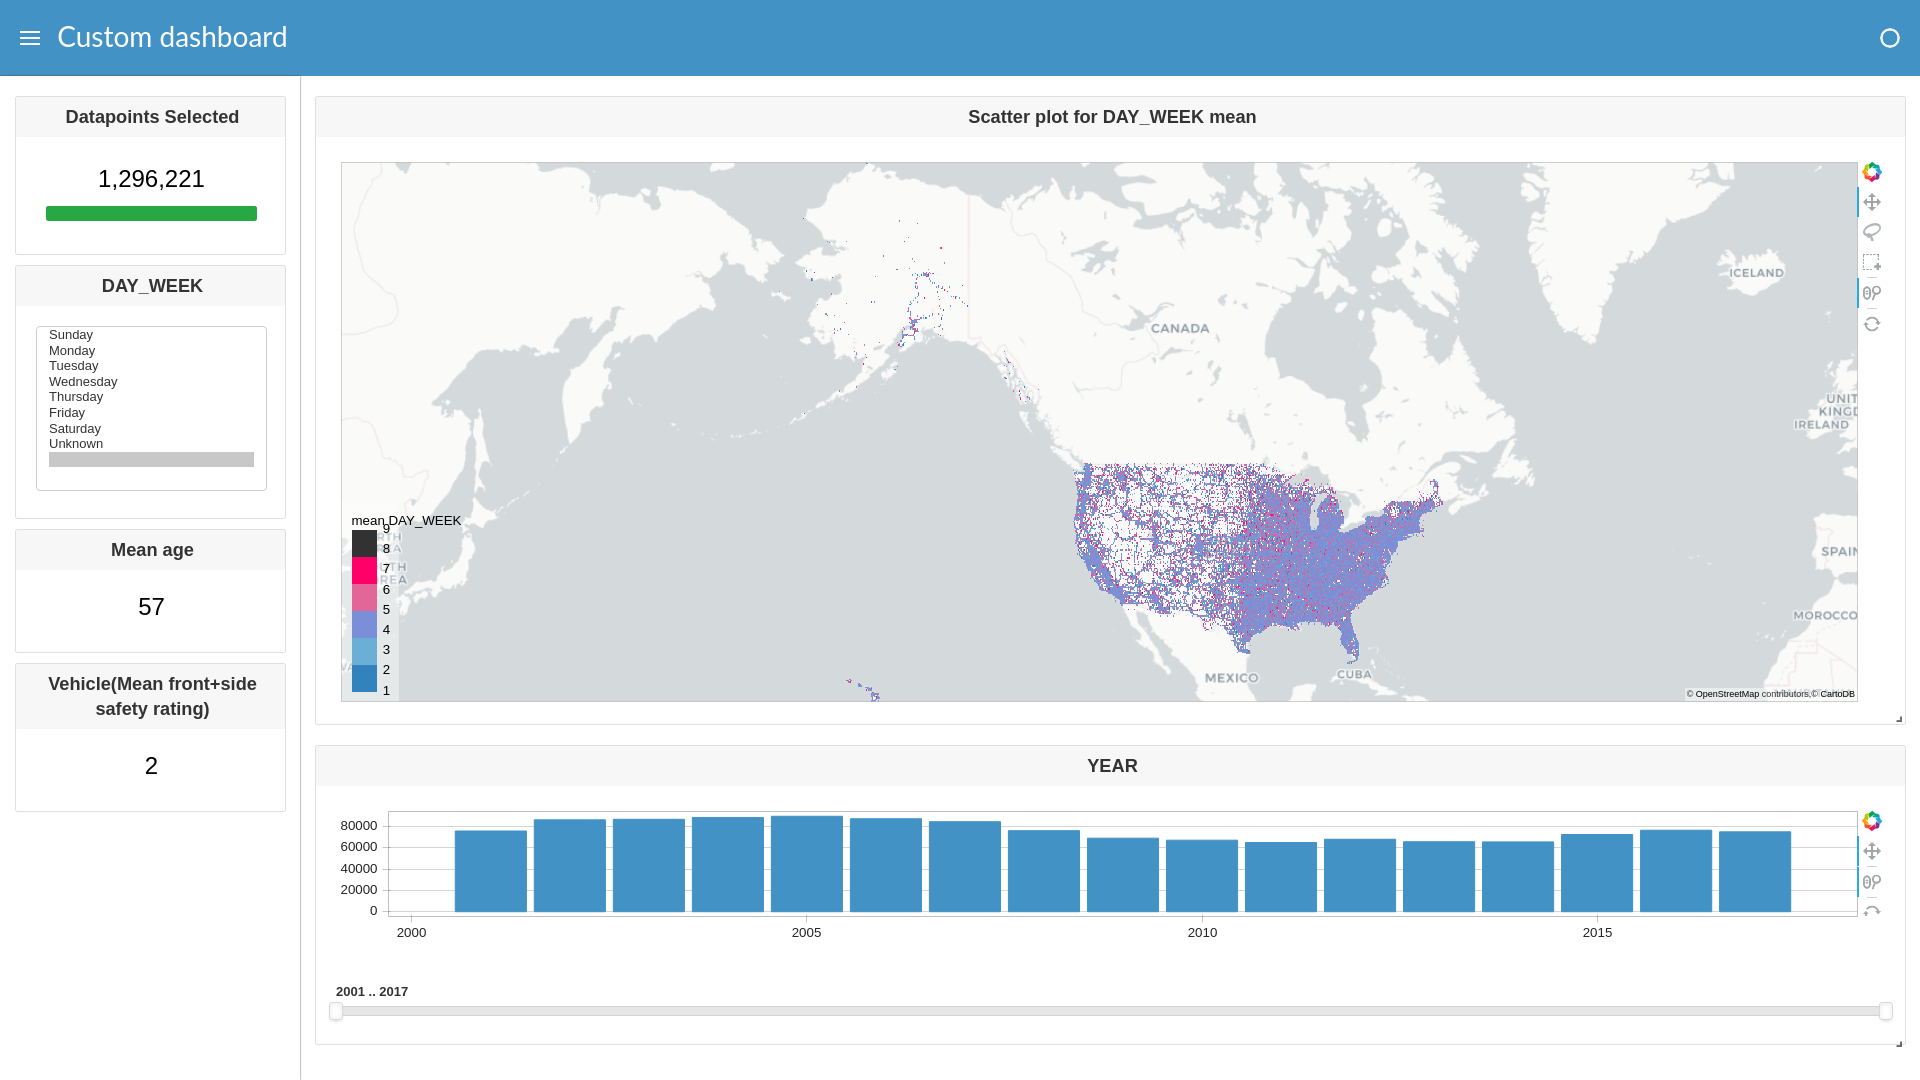

In [41]:
# preview, uncomment below line to see the dashboard preview in a notebook cell
# await d.preview()

#for using the interactive web-app version, use d.app() for in notebook, and d.show() for using it in a separate window as a web-app

#### 6. Run the dashboard

In [ ]:
"""
1. d.show('current_notebook_url:current_notebook_port') remote dashboard

2. d.app() inline within the notebook cell

Incase you need to stop the server:

- d.stop()
"""
# uncomment the line below to start the dashboard in the notebook
# d.app()

#### 6. After you do some interactions, you can take a snapshot of the current state and save it as a dataframe!

In [19]:
current_state_df = d.export()

no querying done, returning original dataframe


In [20]:
current_state_df

,STATE,ST_CASE,VEH_NO,PER_NO,COUNTY,CITY,DAY,MONTH,YEAR,DAY_WEEK,...,ROUTE,RELJCT2,AGE,LAG_HRS,ALC_RES,UNITS_SOLD,LATITUDE,LONGITUD,dropoff_x,dropoff_y
__index_level_0__,,,,,,,,,,,,,,,,,,,,,
0,1,10001.0,1,1,831,968,19,2,2017,1,...,1,1,42,0,0.96,186161.0,33.335661,-87.007094,-9.685585e+06,3.939943e+06
1,1,10002.0,1,1,1009,5923,14,2,2017,3,...,1,1,43,0,0.00,150219.0,34.661528,-86.786853,-9.661068e+06,4.117979e+06
2,1,10003.0,1,1,1120,8314,31,1,2017,3,...,1,1,63,999,0.00,0.0,32.366519,-86.145281,-9.589649e+06,3.811519e+06
3,1,10003.0,2,1,1120,8314,31,1,2017,3,...,1,1,47,0,0.00,207479.0,32.366519,-86.145281,-9.589649e+06,3.811519e+06
4,1,10003.0,3,1,1120,8314,31,1,2017,3,...,1,1,64,999,0.96,0.0,32.366519,-86.145281,-9.589649e+06,3.811519e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3891287,56,560154.0,1,2,1609,0,29,12,2001,7,...,1,1,29,0,0.96,0.0,41.717372,-107.776083,-1.199758e+07,5.118737e+06
3891288,56,560154.0,1,3,1609,0,29,12,2001,7,...,1,1,10,999,0.96,0.0,41.717372,-107.776083,-1.199758e+07,5.118737e+06
3891289,56,560154.0,1,4,1609,0,29,12,2001,7,...,1,1,9,999,0.96,0.0,41.717372,-107.776083,-1.199758e+07,5.118737e+06
